<h2> Load Data <h2>

In [1]:
import scanpy as sc
import pandas as pd

adata_path = '/home/nas2/biod/machuanlong/data/P22/ATAC/adata_peaks_normalized.h5ad'
seq_path = '/home/nas2/biod/machuanlong/data/P22/ATAC/seqs.txt'

adata = sc.read_h5ad(adata_path)
seq = pd.read_csv(seq_path, sep='\t')

<h2> Running SpaDC <h2>

In [2]:
import torch
import SpaDC 

SpaDC.train_SpaDC(adata, seq, n_epochs=100, batch_size=1024, save_model=True, device=torch.device('cuda:8'))

<h2> Benchmark <h2>

<h3> Spatial plots <h3>

2025-05-28 11:48:59.316970: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 11:48:59.622555: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-28 11:48:59.622587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-28 11:48:59.661882: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-28 11:48:59.737265: I tensorflow/core/platform/cpu_feature_guar

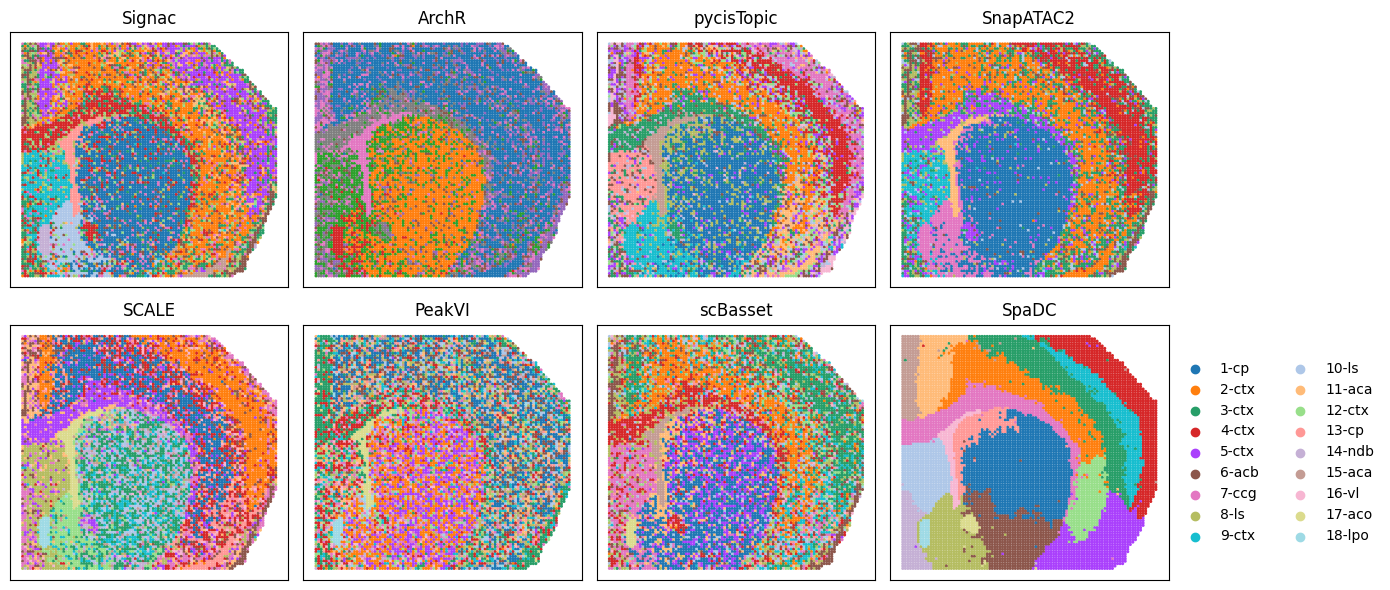

In [3]:
import matplotlib.pyplot as plt

result_path = '/home/nas2/biod/machuanlong/result/p22_ATAC_result.h5ad'

result = sc.read_h5ad(result_path)
result.obsm['SpaDC'] = adata.obsm['SpaDC']

sc.pp.neighbors(result, use_rep='scBasset') 
res1, _ = SpaDC.getNClusters(result, 18)
sc.tl.leiden(result, key_added='scBasset', resolution=res1)

sc.pp.neighbors(result, use_rep='SCALE') 
res2, _ = SpaDC.getNClusters(result, 18)
sc.tl.leiden(result, key_added='SCALE', resolution=res2)

sc.pp.neighbors(result, use_rep='PeakVI') 
res3, _ = SpaDC.getNClusters(result, 18)
sc.tl.leiden(result, key_added='PeakVI', resolution=res3)

sc.pp.neighbors(result, use_rep='SpaDC') 
res4, _ = SpaDC.getNClusters(result, 18)
sc.tl.leiden(result, key_added='SpaDC', resolution=res4)

cluster_annotation = {
    '0':'1-cp', 
    '1':'2-ctx', 
    '2':'3-ctx', 
    '3':'4-ctx', 
    '4':'5-ctx', 
    '5':'6-acb', 
    '6':'7-ccg', 
    '7':'8-ls', 
    '8':'9-ctx', 
    '9':'10-ls', 
    '10':'11-aca', 
    '11':'12-ctx', 
    '12':'13-cp', 
    '13':'14-ndb', 
    '14':'15-aca', 
    '15':'16-vl', 
    '16':'17-aco', 
    '17':'18-lpo'
}

result.obs['SpaDC'] = result.obs['SpaDC'].map(cluster_annotation).astype('category')
# sc.write("result/p22_ATAC_result.h5ad", result)

f, ax = plt.subplots(2, 4, figsize=(14, 6))
sc.pl.embedding(result, basis='spatial', color='Signac', size=20, ax=ax[0,0], show=False)
sc.pl.embedding(result, basis='spatial', color='ArchR', size=20, ax=ax[0,1], show=False)
sc.pl.embedding(result, basis='spatial', color='pycisTopic', size=20, ax=ax[0,2], show=False)
sc.pl.embedding(result, basis='spatial', color='SnapATAC2', size=20, ax=ax[0,3], show=False)
sc.pl.embedding(result, basis='spatial', color='SCALE', size=20, ax=ax[1,0], show=False)
sc.pl.embedding(result, basis='spatial', color='PeakVI', size=20, ax=ax[1,1], show=False)
sc.pl.embedding(result, basis='spatial', color='scBasset', size=20, ax=ax[1,2], show=False)
sc.pl.embedding(result, basis='spatial', color='SpaDC', size=20, ax=ax[1,3], show=False)

ax[0,0].get_legend().remove()
ax[0,1].get_legend().remove()
ax[0,2].get_legend().remove()
ax[0,3].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()
ax[1,2].get_legend().remove()
# ax[1,3].get_legend().remove()

ax[0, 0].set_xlabel('')
ax[0, 1].set_xlabel('')
ax[0, 2].set_xlabel('')
ax[0, 3].set_xlabel('')
ax[1, 0].set_xlabel('')
ax[1, 1].set_xlabel('')
ax[1, 2].set_xlabel('')
ax[1, 3].set_xlabel('')

ax[0, 0].set_ylabel('')
ax[0, 1].set_ylabel('')
ax[0, 2].set_ylabel('')
ax[0, 3].set_ylabel('')
ax[1, 0].set_ylabel('')
ax[1, 1].set_ylabel('')
ax[1, 2].set_ylabel('')
ax[1, 3].set_ylabel('')

plt.tight_layout()
# plt.savefig('figures/p22_ATAC_result.png')
plt.show()

<h3> Metrics <h3>

/tmp/ipykernel_1017552/3191090545.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Signac', 'ArchR', 'pycisTopic', 'SnapATAC2', 'SCALE', 'PeakVI', 'scBasset', 'SpaDC'])


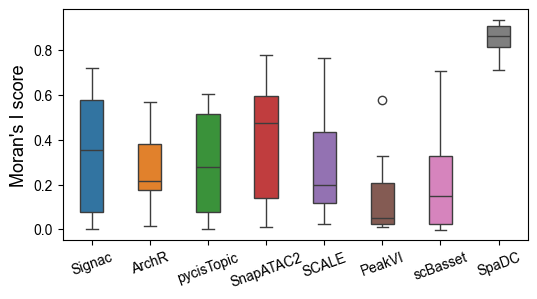

In [4]:
import squidpy as sq
import seaborn as sns
import anndata as ad

# Moran’s I
# Signac
Signac_categories = result.obs['Signac']
Signac_one_hot_encoded =  pd.get_dummies(Signac_categories)
Signac_one_hot_encoded = Signac_one_hot_encoded * 1

adata_Signac = ad.AnnData(Signac_one_hot_encoded.values)
adata_Signac.obsm['spatial'] = result.obsm['spatial']
sq.gr.spatial_neighbors(adata_Signac, spatial_key='spatial')
sq.gr.spatial_autocorr(adata_Signac, mode="moran")
Signac_moranI = adata_Signac.uns['moranI']['I'].tolist()

# ArchR
ArchR_categories = result.obs['ArchR']
ArchR_one_hot_encoded =  pd.get_dummies(ArchR_categories)
ArchR_one_hot_encoded = ArchR_one_hot_encoded * 1

adata_ArchR = ad.AnnData(ArchR_one_hot_encoded.values)
adata_ArchR.obsm['spatial'] = result.obsm['spatial']
sq.gr.spatial_neighbors(adata_ArchR, spatial_key='spatial')
sq.gr.spatial_autocorr(adata_ArchR, mode="moran")
ArchR_moranI = adata_ArchR.uns['moranI']['I'].tolist()

# pycisTopic
pycisTopic_categories = result.obs['pycisTopic']
pycisTopic_one_hot_encoded =  pd.get_dummies(pycisTopic_categories)
pycisTopic_one_hot_encoded = pycisTopic_one_hot_encoded * 1

adata_pycisTopic = ad.AnnData(pycisTopic_one_hot_encoded.values)
adata_pycisTopic.obsm['spatial'] = result.obsm['spatial']
sq.gr.spatial_neighbors(adata_pycisTopic, spatial_key='spatial')
sq.gr.spatial_autocorr(adata_pycisTopic, mode="moran")
pycisTopic_moranI = adata_pycisTopic.uns['moranI']['I'].tolist()

# SnapATAC2
SnapATAC2_categories = result.obs['SnapATAC2']
SnapATAC2_one_hot_encoded =  pd.get_dummies(SnapATAC2_categories)
SnapATAC2_one_hot_encoded = SnapATAC2_one_hot_encoded * 1

adata_SnapATAC2 = ad.AnnData(SnapATAC2_one_hot_encoded.values)
adata_SnapATAC2.obsm['spatial'] = result.obsm['spatial']
sq.gr.spatial_neighbors(adata_SnapATAC2, spatial_key='spatial')
sq.gr.spatial_autocorr(adata_SnapATAC2, mode="moran")
SnapATAC2_moranI = adata_SnapATAC2.uns['moranI']['I'].tolist()

# SCALE
SCALE_categories = result.obs['SCALE']
SCALE_one_hot_encoded =  pd.get_dummies(SCALE_categories)
SCALE_one_hot_encoded = SCALE_one_hot_encoded * 1

adata_SCALE = ad.AnnData(SCALE_one_hot_encoded.values)
adata_SCALE.obsm['spatial'] = result.obsm['spatial']
sq.gr.spatial_neighbors(adata_SCALE, spatial_key='spatial')
sq.gr.spatial_autocorr(adata_SCALE, mode="moran")
SCALE_moranI = adata_SCALE.uns['moranI']['I'].tolist()

# PeakVI
PeakVI_categories = result.obs['PeakVI']
PeakVI_one_hot_encoded =  pd.get_dummies(PeakVI_categories)
PeakVI_one_hot_encoded = PeakVI_one_hot_encoded * 1

adata_PeakVI = ad.AnnData(PeakVI_one_hot_encoded.values)
adata_PeakVI.obsm['spatial'] = result.obsm['spatial']
sq.gr.spatial_neighbors(adata_PeakVI, spatial_key='spatial')
sq.gr.spatial_autocorr(adata_PeakVI, mode="moran")
PeakVI_moranI = adata_PeakVI.uns['moranI']['I'].tolist()

# scBasset
scBasset_categories = result.obs['scBasset']
scBasset_one_hot_encoded =  pd.get_dummies(scBasset_categories)
scBasset_one_hot_encoded = scBasset_one_hot_encoded * 1

adata_scBasset = ad.AnnData(scBasset_one_hot_encoded.values)
adata_scBasset.obsm['spatial'] = result.obsm['spatial']
sq.gr.spatial_neighbors(adata_scBasset, spatial_key='spatial')
sq.gr.spatial_autocorr(adata_scBasset, mode="moran")
scBasset_moranI = adata_scBasset.uns['moranI']['I'].tolist()

# SpaDC
SpaDC_categories = result.obs['SpaDC']
SpaDC_one_hot_encoded =  pd.get_dummies(SpaDC_categories)
SpaDC_one_hot_encoded = SpaDC_one_hot_encoded * 1

adata_SpaDC = ad.AnnData(SpaDC_one_hot_encoded.values)
adata_SpaDC.obsm['spatial'] = result.obsm['spatial']
sq.gr.spatial_neighbors(adata_SpaDC, spatial_key='spatial')
sq.gr.spatial_autocorr(adata_SpaDC, mode="moran")
SpaDC_moranI = adata_SpaDC.uns['moranI']['I'].tolist()

# 画图
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'

f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(data=[Signac_moranI, ArchR_moranI, pycisTopic_moranI, SnapATAC2_moranI, SCALE_moranI, PeakVI_moranI, scBasset_moranI, SpaDC_moranI],width=0.4)
ax.set_xticklabels(['Signac', 'ArchR', 'pycisTopic', 'SnapATAC2', 'SCALE', 'PeakVI', 'scBasset', 'SpaDC'])
plt.xticks(rotation=20) 
plt.ylabel('Moran\'s I score', fontsize=13)
# plt.savefig('figures/p22_ATAC_moranI.png', dpi=300, bbox_inches='tight')
plt.show()

<h3> Denoise <h3>

<h4> Differential chromatin analysis <h4>

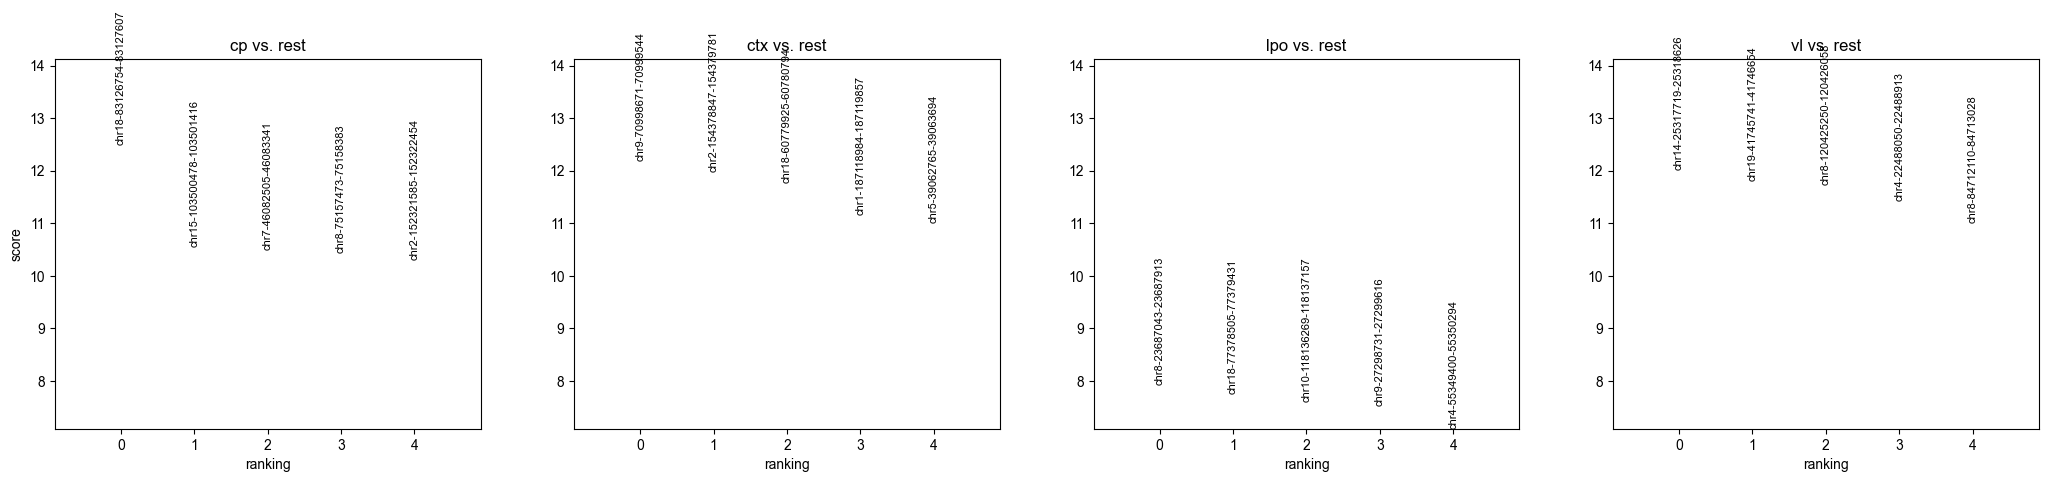

In [5]:
import episcanpy as epi

adata = sc.read_h5ad(adata_path)
result = sc.read_h5ad(result_path)

cluster_annotation = {
    '1-cp':'cp', 
    '2-ctx':'ctx', 
    '3-ctx':'ctx', 
    '4-ctx':'ctx', 
    '5-ctx':'ctx', 
    '6-acb':'acb', 
    '7-ccg':'ccg', 
    '8-ls':'ls', 
    '9-ctx':'ctx', 
    '10-ls':'ls', 
    '11-aca':'aca', 
    '12-ctx':'ctx', 
    '13-cp':'cp', 
    '14-ndb':'ndb', 
    '15-aca':'aca', 
    '16-vl':'vl', 
    '17-aco':'aco', 
    '18-lpo':'lpo'
}

result.obs['SpaDC'] = result.obs['SpaDC'].map(cluster_annotation).astype('category')
adata.obs['SpaDC'] = result.obs['SpaDC'].values

epi.pp.binarize(adata)
epi.pp.normalize_total(adata)
epi.pp.log1p(adata)
adata.raw = adata

epi.tl.rank_features(adata, groupby='SpaDC', omic='ATAC', groups=['cp', 'ctx', 'lpo', 'vl'])
epi.pl.rank_feat_groups(adata, n_features=5)
# plt.savefig('figures/p22_ATAC_differ_peak.png')
plt.show()

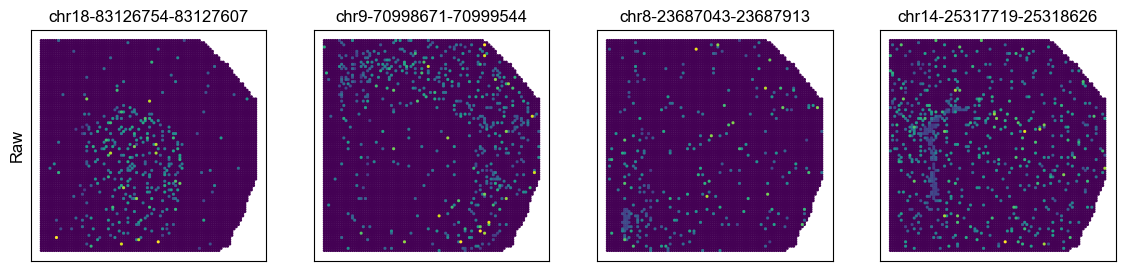

In [6]:
f, ax = plt.subplots(1, 4, figsize=(14, 3))
sc.pl.embedding(adata, basis='spatial', color='chr18-83126754-83127607', vmin=0, vmax=1.5, size=20, ax=ax[0],show=False, colorbar_loc=None) 
sc.pl.embedding(adata, basis='spatial', color='chr9-70998671-70999544', vmin=0, vmax=1.5, size=20, ax=ax[1], show=False, colorbar_loc=None)
sc.pl.embedding(adata, basis='spatial', color='chr8-23687043-23687913', vmin=0, vmax=1.5, size=20, ax=ax[2], show=False, colorbar_loc=None)  
sc.pl.embedding(adata, basis='spatial', color='chr14-25317719-25318626', vmin=0, vmax=1.5, size=20, ax=ax[3], show=False, colorbar_loc=None) 

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[3].set_xlabel('')

ax[0].set_ylabel('Raw', fontsize=12)
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')

# plt.savefig('figures/p22_ATAC_differ_peak_fig.png')
plt.show()

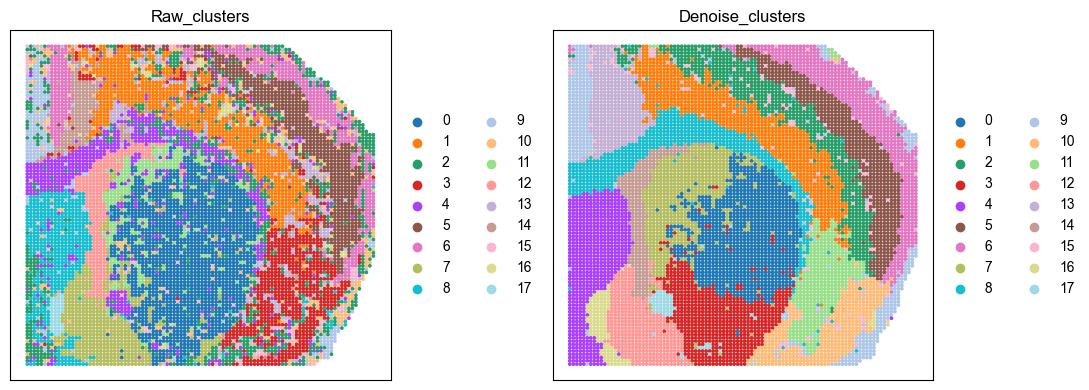

In [7]:
adata = sc.read_h5ad(adata_path)

model_state_dict = '/home/nas2/biod/machuanlong/result/model.pt'

adata_denoise = SpaDC.get_denoise_adata(adata, seq, model_state_dict)

adata_denoise.obsm['spatial'] = adata.obsm['spatial']

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sq.gr.spatial_neighbors(adata, coord_type='grid', spatial_key='spatial')
adata.obsp['connectivities'] = (0.5 * adata.obsp['connectivities'] + 0.5 * adata.obsp['spatial_connectivities'])
res1, _ = SpaDC.getNClusters(adata, 18)
sc.tl.leiden(adata, key_added='Raw_clusters', resolution=res1)

sc.pp.normalize_total(adata_denoise, target_sum=1e4)
sc.pp.log1p(adata_denoise)
sc.tl.pca(adata_denoise)
sc.pp.neighbors(adata_denoise, n_neighbors=15, n_pcs=30)
sq.gr.spatial_neighbors(adata_denoise, coord_type='grid', spatial_key='spatial')
adata_denoise.obsp['connectivities'] = (0.5 * adata_denoise.obsp['connectivities'] + 0.5 * adata_denoise.obsp['spatial_connectivities'])
res2, _ = SpaDC.getNClusters(adata_denoise, 18)
sc.tl.leiden(adata_denoise, key_added='Denoise_clusters', resolution=res2)

f, ax = plt.subplots(1, 2, figsize=(11, 4))
sc.pl.embedding(adata, basis='spatial', color='Raw_clusters', size=30, ax=ax[0], show=False)
sc.pl.embedding(adata_denoise, basis='spatial', color='Denoise_clusters', size=30, ax=ax[1], show=False)

ax[0].set_xlabel('')
ax[1].set_xlabel('')

ax[0].set_ylabel('')
ax[1].set_ylabel('')

plt.tight_layout()
# plt.savefig('figures/p22_denoise.png')
plt.show()

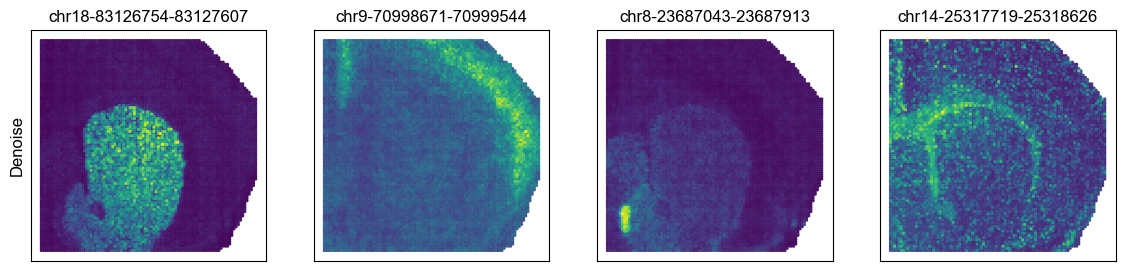

In [8]:
adata.X = adata_denoise.X

f, ax = plt.subplots(1, 4, figsize=(14, 3))
sc.pl.embedding(adata, basis='spatial', color='chr18-83126754-83127607', vmin=0, size=20, ax=ax[0],show=False, colorbar_loc=None) 
sc.pl.embedding(adata, basis='spatial', color='chr9-70998671-70999544', vmin=0, size=20, ax=ax[1], show=False, colorbar_loc=None)
sc.pl.embedding(adata, basis='spatial', color='chr8-23687043-23687913', vmin=0, size=20, ax=ax[2], show=False, colorbar_loc=None)  
sc.pl.embedding(adata, basis='spatial', color='chr14-25317719-25318626', vmin=0, size=20, ax=ax[3], show=False, colorbar_loc=None) 

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[3].set_xlabel('')

ax[0].set_ylabel('Denoise', fontsize=12)
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')

# plt.savefig('figures/p22_ATAC_differ_peak_fig_denoise.png')
plt.show()